### Facies Prediction using Machine Learning

In [15]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

In [16]:
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [17]:
data = pd.read_csv('well.csv')
data['VELP']=1000000/data.DT
data = data[['DEPTH', 'RHOB', 'VELP', 'GR', 'FACIES']]
data = data.dropna(how='any')
data

,DEPTH,RHOB,VELP,GR,FACIES
1427,262.0500,1998.9065,1947.364680,20.8059,1
1428,262.2000,1989.1794,1947.391984,21.1575,1
1429,262.3500,1985.5889,1947.420427,21.3494,1
1430,262.5000,2008.2076,1947.448492,21.1685,1
1431,262.6500,2026.0713,1947.476937,21.1536,1
...,...,...,...,...,...
9675,1499.2500,1787.5444,1879.089251,27.6273,1
9676,1499.4000,1814.1691,1869.644637,28.5281,1
9677,1499.5500,1861.6497,1861.538055,28.5813,1
9678,1499.7001,1880.3978,1861.285813,28.5813,1


In [18]:
def butter_lowpass(cutoff, fs, order=5):
	nyq = 0.5 * fs
	normal_cutoff = cutoff / nyq
	b, a = butter(order, normal_cutoff, btype='low', analog=False)
	return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
	b, a = butter_lowpass(cutoff, fs, order=order)
	y = filtfilt(b, a, data)
	return y

In [19]:
data['RHOBF']= butter_lowpass_filter(data.RHOB.values,10,1000/1, order=5)
data['VELPF']= butter_lowpass_filter(data.VELP.values,10,1000/1, order=5)
data['GRF']= butter_lowpass_filter(data.GR.values,10,1000/1, order=5)
data = data[['DEPTH', 'RHOBF', 'VELPF', 'GRF', 'FACIES']]

In [20]:
x_train = data.iloc[:, 1:4].values
y_train = data.iloc[:, -1].values
sc = StandardScaler()
x_train = sc.fit_transform(x_train)

model = KNeighborsClassifier(n_neighbors=5)
model.fit(x_train,y_train)
x_test = x_train

<function matplotlib.pyplot.show(close=None, block=None)>

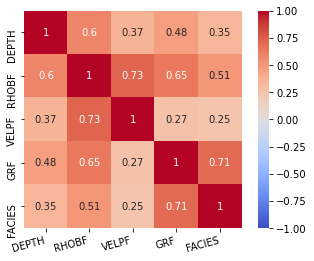

In [21]:
#### confusion matrix
cor_train =data.corr()
cor_test = data.corr()
ax = sns.heatmap(
	cor_train,
	vmin=-1, vmax=1, center=0,
	cmap='coolwarm',
	square=True, annot=True)
ax.set_xticklabels(
	ax.get_xticklabels(),
	rotation=15,
	horizontalalignment='right')
plt.show

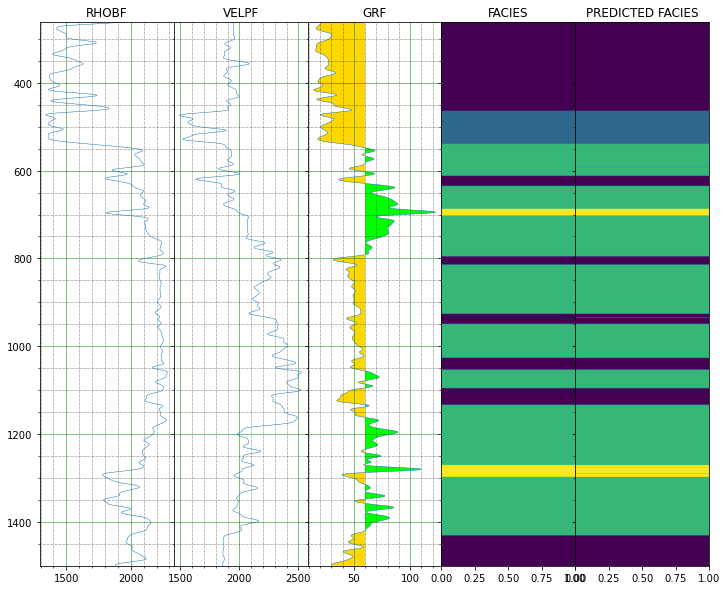

In [22]:
y_predict = model.predict(x_test)
mneumonics = list(data.columns)
data = data.values
rows, cols = 1, 5
fig, ax = plt.subplots(nrows= rows, ncols=cols, figsize=(12, 10), sharey=True)
#mneumonics = ['RHOB', 'DT', 'GR', 'FACIES', 'PRED']

for i in range(cols):
	if i < cols-2:
		ax[i].plot(data[:,i+1], data[:,0], linewidth='0.5')
		ax[i].set_ylim(max(data[:,0]), min(data[:,0]),0)
		ax[i].minorticks_on()
		ax[i].grid(which='major', linestyle='-', linewidth='0.5', color='green')
		ax[i].grid(which='minor', linestyle=':', linewidth='0.5', color='black')
		ax[i].set_title('%s' %mneumonics[i+1])
	elif i == cols-2:
		F = np.vstack((data[:,-1],data[:,-1])).T
		m = ax[i].imshow(F, aspect='auto', extent=[0, 1, max(data[:,0]), min(data[:,0])])
		ax[i].set_title('%s' %mneumonics[i+1])
	elif i == cols-1:
		F = np.vstack((y_predict, y_predict)).T
		m = ax[i].imshow(F, aspect='auto', extent=[0, 1, max(data[:,0]), min(data[:,0])])
		ax[i].set_title('PREDICTED FACIES')
        
cl = 60
y2 = data[:, 3]
y1 = y2*0+cl
ax[2].fill_betweenx(data[:, 0], y1, y2, where=(y1>=y2), color='gold', linewidth=0)
ax[2].fill_betweenx(data[:, 0], y1, y2, where=(y1<y2), color='lime', linewidth=0)

plt.subplots_adjust(wspace=0)
plt.show()